# Evaluation suite

***

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import sqlite3 as sql
import math
from matplotlib import pyplot as plt, dates, colors, patches
from datetime import datetime, timedelta
from dateutil.parser import parse
from tqdm import tqdm

%matplotlib inline

In [2]:
plt.rcParams['font.size'] = 14

***

## Evaluation sandbox

In [3]:
import process_NEMO_drifters as tools

In [4]:
df = pd.read_csv('/home/bmoorema/project/SalishSea/obs/CitSci2015_2019.csv', parse_dates=True, index_col='datetime_utc')

/home/bmoorema/venvs/SSC-jupyter/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,6,7,8,9,10,13) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
kwargs = {'minute': 30, 'second': 0, 'microsecond': 0}
times = df.index.values.astype('datetime64[s]').astype(datetime)
times = np.hstack([times + timedelta(hours=hour) for hour in range(-1, 2)])
times = np.unique([t.replace(**kwargs) for t in times])

In [ ]:
def main_routine(
    runID, startdate, enddate,
    path_NEMO='/scratch/bmoorema/Results/Currents',
    path_obs='/home/bmoorema/project/SalishSea/obs',
    path_save='/scratch/bmoorema/Drifters',

):
    """
    """

    # Initialize
    daterange = [startdate, enddate]
    datestr = '_'.join(daterange)
    rundir = f'SalishSeaCast_currenttuning_{runID}_{datestr}'

    # Load NEMO
    fn = f'{path_NEMO}/{rundir}/SalishSea_1h_{datestr}_grid_T.nc'
    for var in ['votemper', 'vosaline']:
        NEMO[var] = xr.open_dataset(fn).vosaline.sel(time_counter=times)

    # Get velocities and save to database
    gridvars, gridref = get_grid_variables()
    for n, ID in enumerate(IDs):
        velocities = get_NEMO_velocities(ID, drifters, NEMO, gridvars, gridref)

***

## Evaluate velocities

In [16]:
def rotate_vel(u_in, v_in, theta=29):
    """Rotate velocities from map coordinates to grid coordinates
    """
    
    theta_rad = math.radians(theta)
    u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)
    v_out = -u_in * np.sin(theta_rad) + v_in * np.cos(theta_rad)
    
    return u_out, v_out

In [17]:
dateranges = ['20160401_20160930'] #, '20161001_20170331', '20170401_20170930']
runIDs = ['frachs08', 'base', 'frachs13', 'charnock']
velocities = {runID: {'obs': {'u': [], 'v': []}, 'NEMO': {'u': [], 'v': []}} for runID in runIDs}

for runID in runIDs:

    for daterange in dateranges:

        # Open database
        con = sql.connect(f'/scratch/bmoorema/Drifters/SSCdrifters_{runID}_{daterange}.sqlite')

        # Print table names
        cursor = con.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
        for drifter in cursor.fetchall():

            # Read a table to Pandas dataframe
            df = pd.read_sql_query(f'SELECT * from {drifter[0]}', con, parse_dates='time')

            # Compute drifter velocities from positions
            times = df['time'].values.astype('datetime64[s]').astype(datetime)
            lons, lats = [df[var].values for var in ('longitude', 'latitude')]
            dt = np.array([t.total_seconds() for t in np.diff(times)])
            uv = []
            for coord, theta in zip([lons, lats], [0, np.deg2rad(lats[:-1])]):
                uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))

            # Add to lists
            for var, val in zip(['u', 'v'], rotate_vel(*uv)):
                velocities[runID]['obs'][var].append(val)
                velocities[runID]['NEMO'][var].append(df[var].values[:-1])

        con.close()
    
    for key in ['obs', 'NEMO']:
        for var in ['u', 'v']:
            velocities[runID][key][var] = np.hstack(velocities[runID][key][var])

/tmp/ipykernel_15702/2147078208.py:26: RuntimeWarning: divide by zero encountered in true_divide
  uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
/tmp/ipykernel_15702/2147078208.py:26: RuntimeWarning: invalid value encountered in true_divide
  uv.append(np.diff(coord) / dt * 111000 * np.cos(theta))
/tmp/ipykernel_15702/3316846.py:6: RuntimeWarning: invalid value encountered in add
  u_out = u_in * np.cos(theta_rad) + v_in * np.sin(theta_rad)


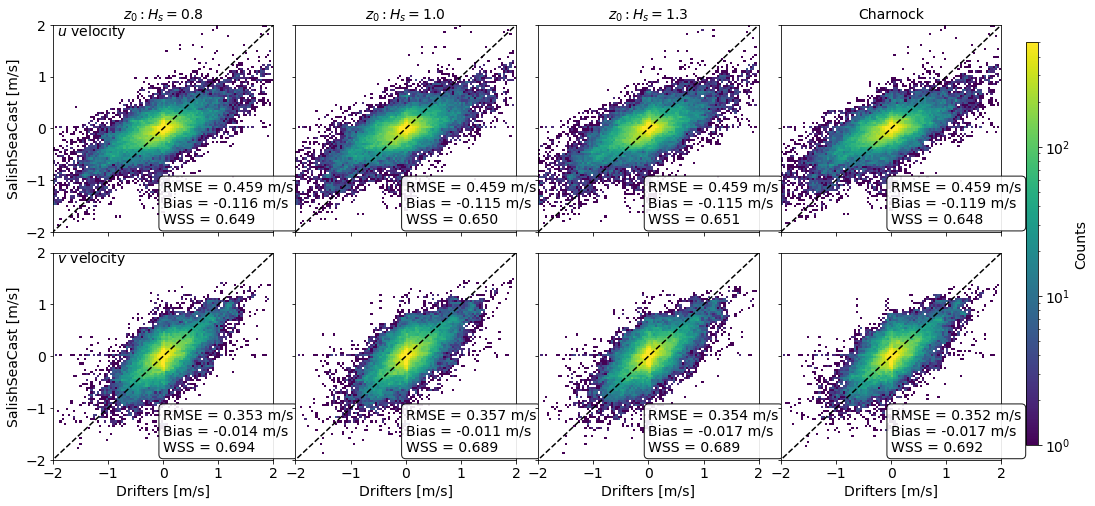

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(17, 8), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
xlim, ylim = [-2, 2], [-2, 2]
props = dict(boxstyle='round', facecolor='w', alpha=0.9)
for col, runID, title in zip(axs.T, runIDs, ['$z_0:H_s=0.8$', '$z_0:H_s=1.0$', '$z_0:H_s=1.3$', 'Charnock']):
    for ax, var in zip(col, ['u', 'v']):
        x, y = [velocities[runID][key][var] for key in ('obs', 'NEMO')]
        index = np.logical_and(np.isfinite(x), np.isfinite(y))
        x, y = x[index], y[index]
        
        # Calc stats
        MSE = np.mean((y - x)**2)
        RMSE = np.sqrt(MSE)
        bias = np.mean(abs(y)) - np.mean(abs(x))
        WSS = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
        
        # Plot data
        _, _, _, c = ax.hist2d(x, y, bins=100, range=[xlim, ylim], norm=colors.LogNorm(vmin=1, vmax=500))
        ax.plot([-4, 4], [-4, 4], 'k--')
        ax.text(0.5, 0.04, f'RMSE = {RMSE:.3f} m/s\nBias = {bias:.3f} m/s\nWSS = {WSS:.3f}', bbox=props, transform=ax.transAxes)
        
        # Formatting
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        if runID == 'frachs08':
            ax.set_ylabel('SalishSeaCast [m/s]')
            ax.text(0.02, 0.95, f'${var}$ velocity', transform=ax.transAxes)
        else: ax.yaxis.set_ticklabels('')
        if var == 'u':
            ax.xaxis.set_ticklabels('')
            ax.set_title(title, fontsize=14)
        else: ax.set_xlabel('Drifters [m/s]')
        
cax = fig.add_axes([0.92, 0.15, 0.01, 0.7])
fig.colorbar(c, cax=cax, label='Counts')

#fig.savefig('/scratch/bmoorema/Drifters/figures/earlyruns.pdf', dpi=300, bbox_inches='tight')

***

## Compare salinity fields

In [4]:
mask = xr.open_dataset('/home/bmoorema/MEOPAR/grid/mesh_mask202108.nc')
tmask = mask.tmask[0, 0, ...].values

In [29]:
datestr = '20160401_20160930'
path = '/scratch/bmoorema/Results/Currents/'
fn = f'SalishSea_1h_{datestr}_grid_T.nc'
salinity = {}

for runID in tqdm(['base', 'frachs08', 'frachs13', 'charnock']):
    
    folder = f'SalishSeaCast_currenttuning_{runID}_{datestr}/'
    salinity[runID] = {}
    ds = xr.open_dataset(path + folder + fn).vosaline
    for date in ['2016 Jun 1', '2016 Jul 1', '2016 Aug 1', '2016 Sep 1']:
        slc = {'time_counter': date, 'deptht': 0, 'method': 'nearest'}        
        salinity[runID][date] = ds.sel(**slc).mean(axis=0).values

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:31<00:00, 38.00s/it]


In [39]:
def plot_salinity(date):
    """Plot surface salinity and anomalies between wave cases
    """
    
    fig, axs = plt.subplots(2, 4, figsize=(12, 14), gridspec_kw={'wspace': 0.1, 'hspace': 0.1})
    for col, runID in zip(axs.T, ['frachs08', 'base', 'frachs13', 'charnock']):
        c1 = col[0].contourf(salinity[runID][date], levels=range(5, 31), cmap='viridis', extend='both')
        c2 = col[1].contourf(salinity[runID][date] - salinity['frachs08'][date], levels=np.arange(-3, 3.1, 0.1), cmap='RdBu_r', extend='both')
        col[0].set_title(runID, fontsize=14)
        for ax, c in zip(col, [c1, c2]):
            ax.contourf(tmask, levels=[-0.01, 0.01], colors='gray')
            ax.contour(tmask, levels=[-0.01, 0.01], colors='k')
            ax.set_aspect(5/4.4)
            ax.xaxis.set_ticklabels('')
            ax.yaxis.set_ticklabels('')
            ax.set_xlim([110, 350])
            ax.set_ylim([300, 800])

            if runID == 'charnock':
                pos = ax.get_position()
                cax = fig.add_axes([0.92, pos.y0, 0.01, pos.height])
                fig.colorbar(c, cax=cax, label='g/kg')

***

#### 2016 June 1

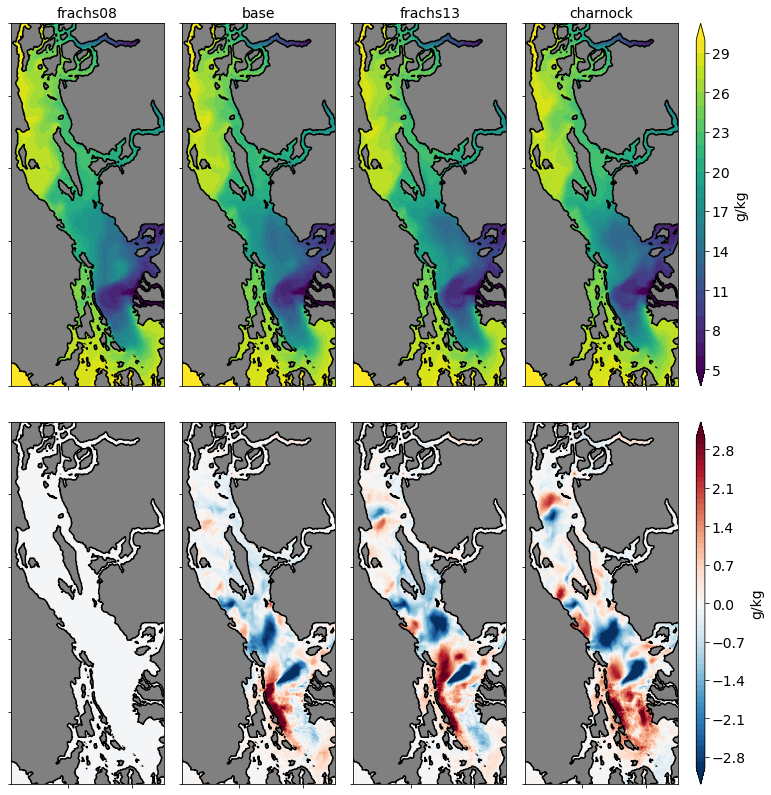

In [40]:
# 2016 Jun 1
plot_salinity('2016 Jun 1')

***

#### 2016 July 1

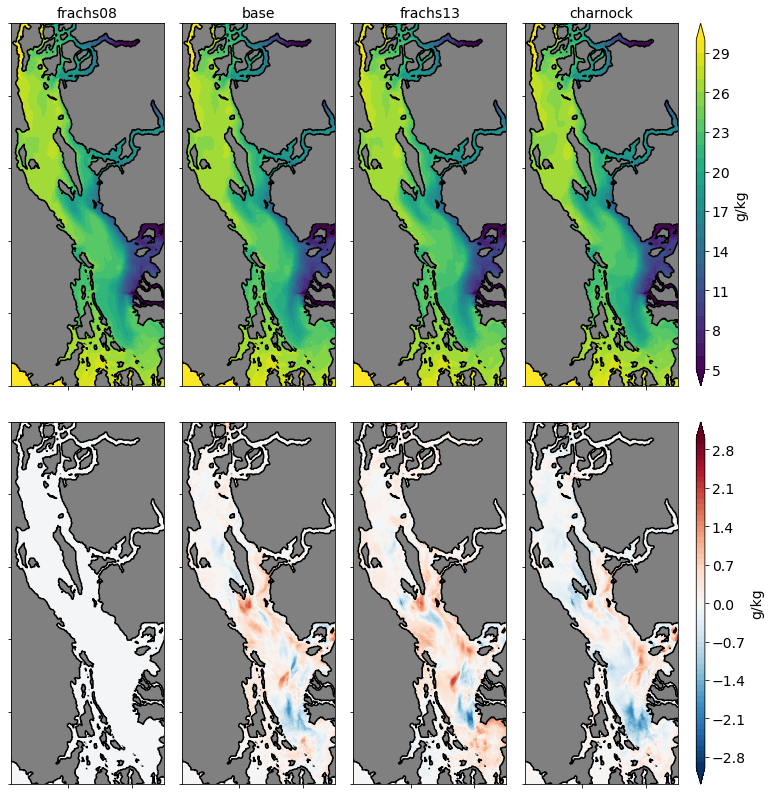

In [41]:
# 2016 Jul 1
plot_salinity('2016 Jul 1')

***

#### 2016 August 1

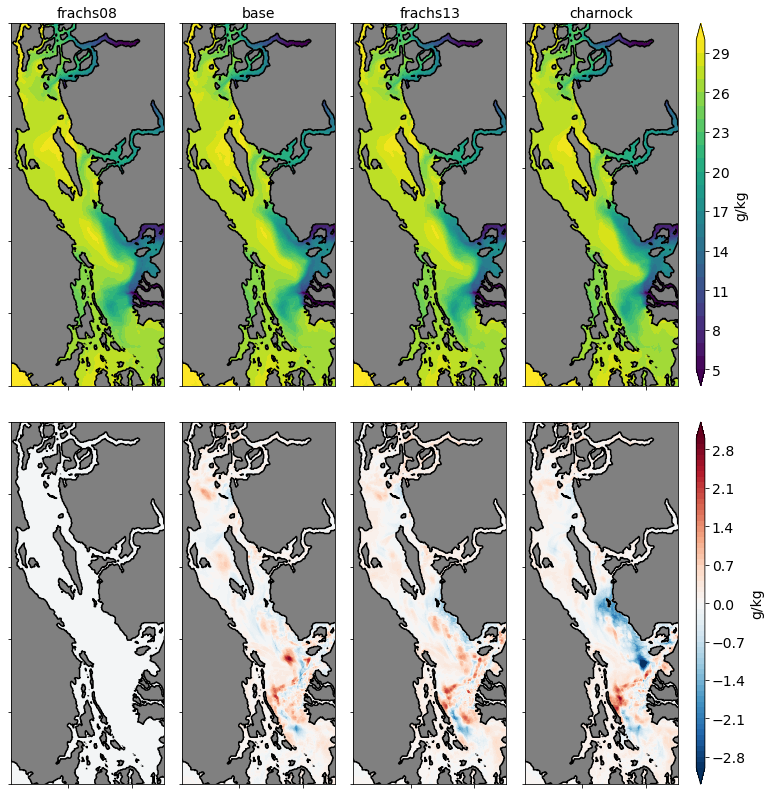

In [42]:
# 2016 Aug 1
plot_salinity('2016 Aug 1')

***

#### 2016 September 1

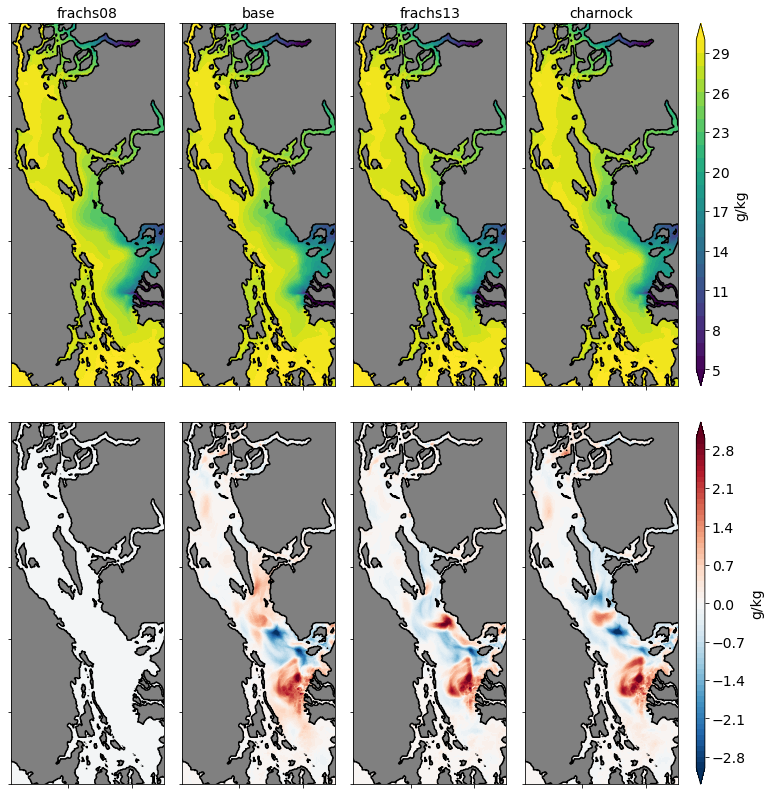

In [43]:
# 2016 Sep 1
plot_salinity('2016 Sep 1')